In [1]:
import semvecpy.vectors.real_vectors as rv
import semvecpy.vectors.semvec_utils as svu
import matplotlib.pyplot as plt
import networkx as nx

/home/NETID/cohenta/anaconda3/envs/pytorch/lib/python3.9/site-packages/semvecpy/vectors/semvec_utils.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
!wget https://zenodo.org/record/1345333/files/earpx_sw_r5_positional_embeddingvectors.bin

--2023-06-15 21:03:53--  https://zenodo.org/record/1345333/files/earpx_sw_r5_positional_embeddingvectors.bin
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 424556815 (405M) [application/octet-stream]
Saving to: ‘earpx_sw_r5_positional_embeddingvectors.bin’

earpx_sw_r5_positio 100%[===================>] 404.89M   374KB/s    in 19m 24s 

2023-06-15 21:23:21 (356 KB/s) - ‘earpx_sw_r5_positional_embeddingvectors.bin’ saved [424556815/424556815]



In [2]:
vecs = rv.RealVectorStore()

In [3]:
vecs.init_from_file('earpx_sw_r5_positional_embeddingvectors.bin')

500   REAL


  0%|          | 0/424556815 [00:00<?, ?it/s]

In [4]:
#use torch to get pairwise dot products across a set of term vectors
import numpy as np
import torch

def getdots(terms,vecs):
    features = []  
    words = []

    for i in terms:  
        if i in vecs.dict:
            words.append(i)
            features.append(torch.tensor(vecs.get_vector(i).vector))
            
    num_words = len(words) # number of words, in terms of hidden activation vectors (2*words)
    lower_triangle_indices = np.tril_indices_from(np.random.rand(num_words, num_words), k = -1)  # creates a matrix that represents words*2 (i.e., from word representations from both layer 6+7) and gets the indices of the lower triangle, omitting diagonal (k = -1)A
    if (num_words > 0):
        features = torch.stack(features)
        features = torch.nn.functional.normalize(features,p=2,dim=1)
        dots = torch.matmul(features,features.T)
    
    dots[np.diag_indices_from(dots)] = 0
    return dots, words

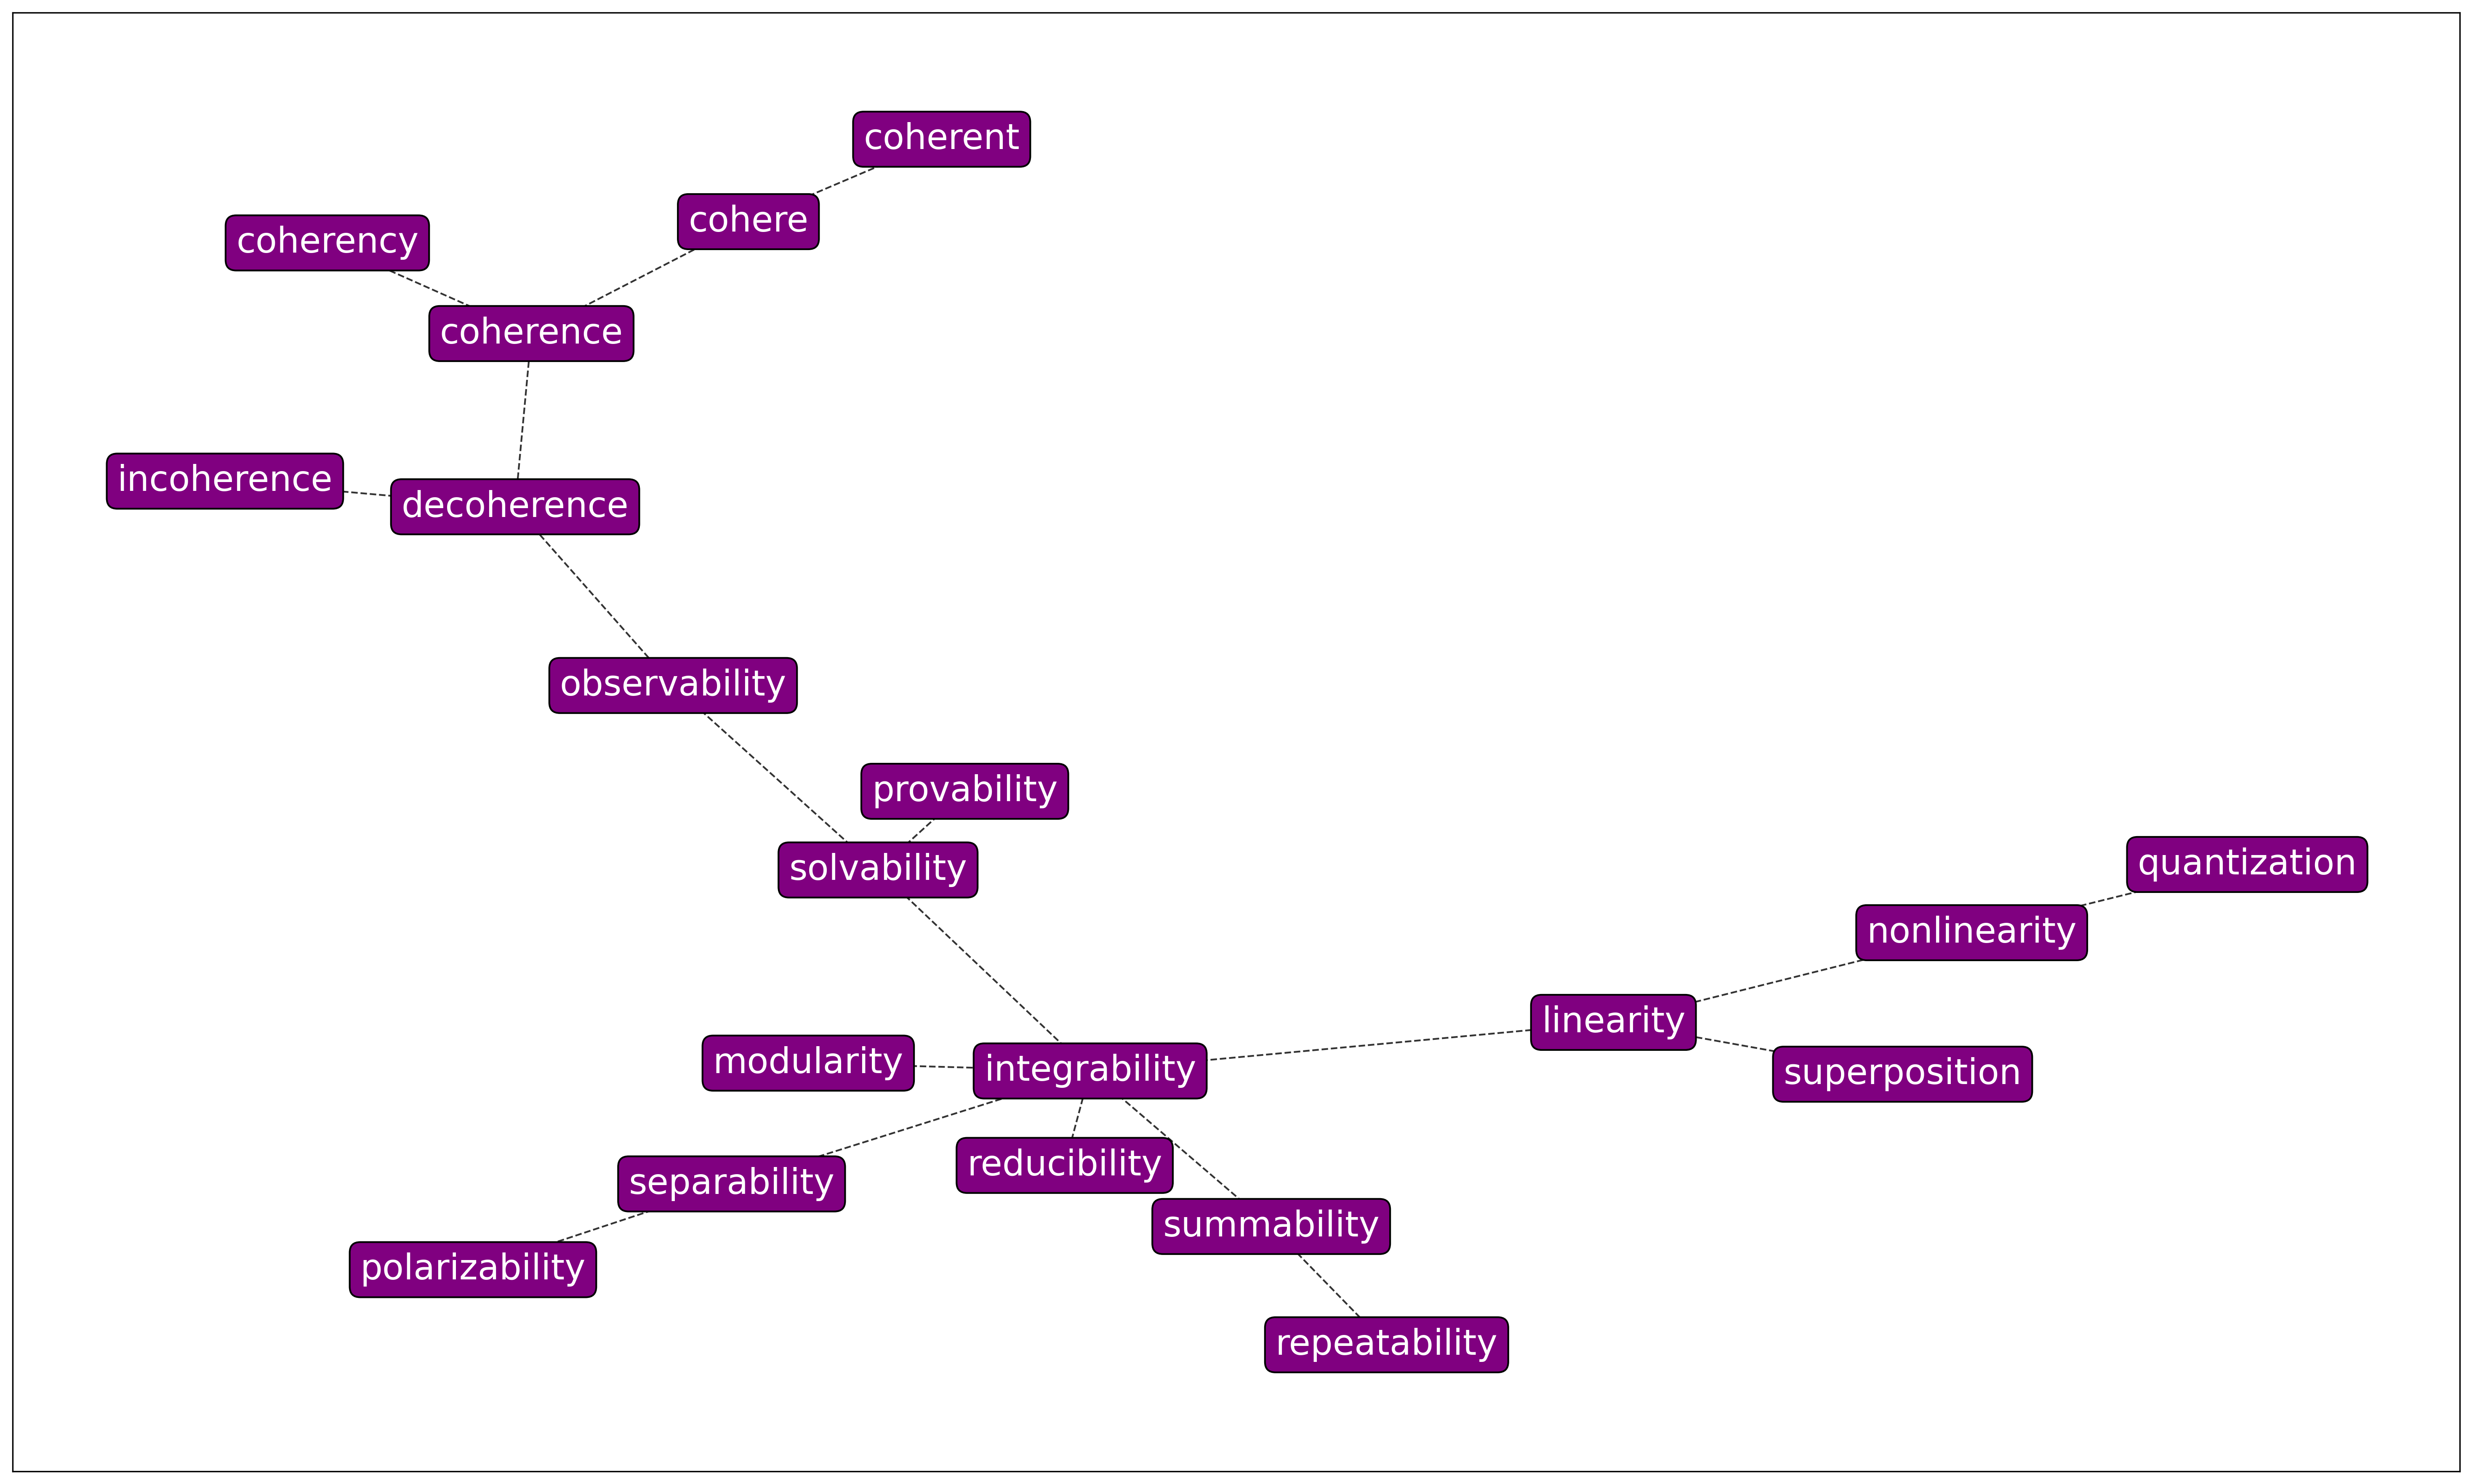

In [5]:
plt.figure(figsize=(25, 15), dpi=300)

terms = [x[1] for x in vecs.knn_term("coherence",20)]
dots, tokens = getdots(terms, vecs)
pfnet = svu.pathfinder(dots.shape[1]-1,np.Infinity,dots)
edges = []

for x in range(pfnet.shape[0]):
        for y in range(pfnet.shape[1]):
            if x != y:
                if pfnet[x,y] > 0:
                    edges.append((tokens[x],tokens[y]))
                
G = nx.Graph()
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw_networkx_edges(G,pos,style='dashed',alpha=0.8)
nx.draw_networkx_labels(G, pos,font_size='20',font_color='white',bbox=dict(facecolor='purple', edgecolor='black',boxstyle='round'))
plt.show()